In [ ]:
#https://stackoverflow.com/questions/44119653/creating-a-boxplot-with-matplotlib
#https://stackoverflow.com/questions/66283023/boxplot-in-python
#https://learnopencv.com/fine-tuning-t5/
#https://www.geeksforgeeks.org/python-how-to-make-a-terminal-progress-bar-using-tqdm/
#https://huggingface.co/learn/nlp-course/chapter6/8?fw=pt
#https://stackoverflow.com/questions/21714400/enumerate-on-specific-items-of-a-list
#https://www.kaggle.com/code/tuckerarrants/text-generation-with-huggingface-gpt2
#https://github.com/ultralytics/ultralytics/issues/2143
#https://www.nltk.org/_modules/nltk/translate/bleu_score.html
#https://www.nltk.org/api/nltk.translate.meteor_score.html
#https://huggingface.co/docs/transformers/model_doc/t5
#https://huggingface.co/transformers/v3.0.2/_modules/transformers/modeling_t5.html#T5ForConditionalGenerati

In [1]:
pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
from tqdm import tqdm

In [3]:
import pandas as pd
from glob import glob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy.sparse import hstack
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import classification_report
from transformers import T5ForConditionalGeneration, T5Tokenizer

In [4]:
data_dirs = list(set(glob('/home/marilu/training_dfs/*.csv')) - 
                 set(glob('/home/marilu/training_dfs/*_ft.csv')) - 
                 set(glob('/home/marilu/training_dfs/*balanced.csv')))
data_dirs

['/home/marilu/training_dfs/political_leaning.csv',
 '/home/marilu/training_dfs/judging_perceiving.csv',
 '/home/marilu/training_dfs/nationality.csv',
 '/home/marilu/training_dfs/birth_year.csv',
 '/home/marilu/training_dfs/gender.csv',
 '/home/marilu/training_dfs/extrovert_introvert.csv',
 '/home/marilu/training_dfs/feeling_thinking.csv',
 '/home/marilu/training_dfs/sensing_intuitive.csv']

In [5]:
data = pd.read_csv(data_dirs[0])
data

,auhtor_ID,post,political_leaning
0,t2_7ramzeng,"You can ""buy"" the show and stream it through t...",right
1,t2_7ramzeng,"me want to play Q*bert Holy shit, based Alex J...",right
2,t2_7ramzeng,Shouldn't rely on any external services or per...,right
3,t2_7ramzeng,PR to a specific person. Usually that just mea...,right
4,t2_7ramzeng,This article's intention is clear that they wa...,right
...,...,...,...
114458,t2_vi35s,hard as I have to go out of my way to find med...,center
114459,t2_vi35s,"WORLD WILL BE MINE! Well if you read it, then ...",center
114460,t2_vyu81f9,Wow super passing there sir. I’m jelly. Aesthe...,left
114461,t2_vyu81f9,compliment your face. Okay fair enough. I supp...,left


In [6]:
vec = TfidfVectorizer()
X_post = vec.fit_transform(data['post'])
y_political = data['political_leaning']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_post, y_political, test_size=0.3, random_state=42)

In [8]:
classifier = LogisticRegression(max_iter=6000)
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=6000)

In [9]:
predictions = classifier.predict(X_test)

In [10]:
print("Classification report:")
print(classification_report(y_test, predictions))

Classification report:
              precision    recall  f1-score   support

      center       0.65      0.77      0.71     14160
        left       0.69      0.61      0.65      9625
       right       0.73      0.63      0.68     10554

    accuracy                           0.68     34339
   macro avg       0.69      0.67      0.68     34339
weighted avg       0.69      0.68      0.68     34339



In [18]:
def obfuscate_all(texts):
    #choose T5 model: Base
    model_name = 't5-base'
    model = T5ForConditionalGeneration.from_pretrained(model_name)
    tokenizer = T5Tokenizer.from_pretrained(model_name)

    #Obfuscate 
    obfuscated_texts = []

    with tqdm(total=len(texts)) as pbar:  
        for text in texts: 
            text = "obfuscate: " + text
            inputs = tokenizer.encode(text, return_tensors="pt", max_length=512, truncation=True)
            outputs = model.generate(inputs, max_length=150, num_return_sequences=1, num_beams=5, temperature=0.9)
            decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
            obfuscated_texts.append(decoded_output)
            pbar.update(1) 

    return obfuscated_texts

In [19]:
X_test_posts = data.loc[y_test.index]['post'].tolist()

In [20]:
X_test_obfuscated_all = obfuscate_all(X_test_posts)

100%|██████████| 34339/34339 [68:17:06<00:00,  7.16s/it]   


In [21]:
X_test_obfuscated_vectorized_all = vec.transform(X_test_obfuscated_all)

In [22]:
# Evaluate obfuscated testset (all instances)
predictions_obfuscated_all = classifier.predict(X_test_obfuscated_vectorized_all)
print("Classification report on obfuscated test set (all instances):")
print(classification_report(y_test, predictions_obfuscated_all))

Classification report on obfuscated test set (all instances):
              precision    recall  f1-score   support

      center       0.48      0.69      0.56     14160
        left       0.43      0.28      0.34      9625
       right       0.49      0.35      0.41     10554

    accuracy                           0.47     34339
   macro avg       0.47      0.44      0.44     34339
weighted avg       0.47      0.47      0.45     34339



In [24]:
file_path = "T5 fully results.txt"

In [25]:
with open(file_path, "w") as file:
    for prediction in predictions:
        file.write(str(prediction) + "\n")  
print(f"Results are saved in {file_path}")

Results are saved in T5 fully results.txt


In [62]:
data

,auhtor_ID,post,political_leaning
0,t2_7ramzeng,"You can ""buy"" the show and stream it through t...",right
1,t2_7ramzeng,"me want to play Q*bert Holy shit, based Alex J...",right
2,t2_7ramzeng,Shouldn't rely on any external services or per...,right
3,t2_7ramzeng,PR to a specific person. Usually that just mea...,right
4,t2_7ramzeng,This article's intention is clear that they wa...,right
...,...,...,...
114458,t2_vi35s,hard as I have to go out of my way to find med...,center
114459,t2_vi35s,"WORLD WILL BE MINE! Well if you read it, then ...",center
114460,t2_vyu81f9,Wow super passing there sir. I’m jelly. Aesthe...,left
114461,t2_vyu81f9,compliment your face. Okay fair enough. I supp...,left


In [27]:
output_file = "T5 results.txt"

In [29]:
with open(output_file, "w", encoding="utf-8") as file:
    for text in X_test_obfuscated_all:
        file.write(text + "\n")

In [44]:
from nltk.translate import meteor_score

In [45]:
original_texts = data.loc[y_test.index]['post'].tolist()
obfuscated_texts = X_test_obfuscated_all

In [46]:
meteor_scores = [meteor_score.single_meteor_score(orig_text, geo_text) for orig_text, geo_text in zip(original_texts, obfuscated_texts)]

In [47]:
meteor_score = sum(meteor_scores) / len(meteor_scores)
print("METEOR-score:", meteor_score)

METEOR-score: 0.024005802230049517


In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0, 0.5, 'Meteor Scores')

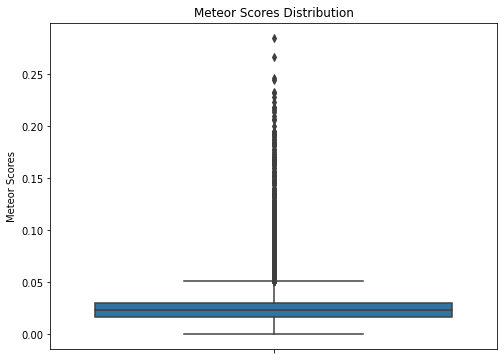

In [49]:
plt.figure(figsize=(8, 6))
sns.boxplot(y=meteor_scores)
plt.title('Meteor Scores Distribution')
plt.ylabel('Meteor Scores')

In [50]:
plt.savefig('meteor_scores_boxplot.png')
plt.show()

<Figure size 432x288 with 0 Axes>

In [51]:
from nltk.translate.bleu_score import corpus_bleu
import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
references = [[text.split()] for text in original_texts]

In [56]:
obfuscated = [text.split() for text in obfuscated_texts]

In [57]:
blue_score = corpus_bleu(references, obfuscated)
print("BLUE-score:", blue_score)

BLUE-score: 1.710067385051556e-11


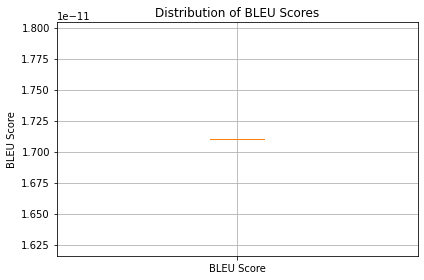

In [61]:
plt.figure(figsize=(6, 4))
plt.boxplot([blue_score], labels=['BLEU Score'])
plt.title('Distribution of BLEU Scores')
plt.ylabel('BLEU Score')
plt.grid(True)
plt.tight_layout()